# Simulating Wireless Interference

Sander Aarts, 2022.


# Introduction
When the number of devices is large, LoRa networks may suffer from _wireless interference_. This interference stems from concurrent packets using the same channels physically disturbing each others' radio signals. This may lead to _packets loss_, and an consequently a  lower throughput of the network. As network planners it is our job to ensure that packet loss due to interference is within acceptable levels. To do so, it is useful to estimate the packet error rate for various network designs. However, testing large networks with thousands of devices in the real world is difficult, costly, and distruptive. Instead, we turn to _simulation_, where running experiments is easy, cheap, and does not disrupt wireless applications of real users. Despite being virtual, these simulations can we can nevertheless inform real-world network design if made realistic where it matters. This notebook is a guide towards this end.
 
On a high level, interference simulations take three main components:
 1. A _network model_ that describes how wireless traffic is generated
 2. An _interference model_ that takes traffic arriving at a recevier and determines which transmissions are received, and which are lost.
 3. Analysis of output from this model.

In this notebook we discuss each point in turn, and show how the `loraplan.interefence`-module is used to this end.

## Contents
This notebook showcases the `loraplan.interference` module from the point of view of interference simulations. The notebook includes the following.
- Setting up a simulate LoRa network, and a LoRa `TrafficGenerator`
    - Choosing the type of network to simulate
    - Choosing distributions from `loraplan.distributions`.
- Generating and understadning LoRa `Traffic`
- Interference models
- Running simulations
- Analyzing simulated output

In [36]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
import collections.abc

from matplotlib import collections  as mc

from scipy.spatial.distance import pdist, squareform

[autoreload of interference failed: Traceback (most recent call last):
  File "/Users/sander/miniforge3/envs/lora/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/Users/sander/miniforge3/envs/lora/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/Users/sander/miniforge3/envs/lora/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/Users/sander/Desktop/lora-network-planner/src/loraplan/interference.py", line 23, in <module>
    from loraplan.distributions import maternThinningI
ModuleNotFoundError: No module named 'loraplan'
]


In [37]:
# set path to where modules are
sys.path.insert(0, os.path.abspath('../src/'))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
# load modules
import loraplan.interference as lpf
import loraplan.distributions as lpd

# Generating wireless traffic with a simulated network

## An abstract approach: A distirbution over traffic

Ultimately, a network model's main purpose is to generate wireless `Traffic`. Here, we take a more abstract route and directly define a probability distribution over `Traffic`-objects. We do so by specifying distributions over critical wireless parameters:
1. `ArrivalProcess`: A distribution (process) over packet arrival times.
2. A distribution over channels
3. A distribution over spreading factors
4. A distribution over airtimes
5. A distribution over (received) power

### 1. An arrival process

Let's specify how packets arrive by instantiating an `ArrivalProcess`.
- First specify a `TimeWindow` with a `buffer`
- Next equip the`TimeWindow` with an `ArrivalProcess`

#### Specify a timeWindow

In [40]:
window = lpd.TimeWindow(0, 1, buffer=1)

In [41]:
print(window)
print(f"\nNote {window.length = } because this includes buffer {window.buff = }.")

TimeWindow(0, 1, buffer=1)

Note window.length = 3 because this includes buffer window.buff = 1.


<br>

#### Specify an ArrivalProcess

With our `TimeWindow` we can proceeed by defining an `ArrivalProcess`.

Let try a `PoissonArrivalProcess` by specifying an arrival rate (packets / second).

In [42]:
arrivals = lpd.PoissonArrivals(timeWindow=window, rate=4.5)

In [43]:
print(arrivals)

HomogeneousPoissonArrivals(TimeWindow(0, 1, buffer=1), rate=4.5)


<br>

#### Sampling arrival times
An `ArrivalProcess` lets us sample arrivals - both their number and time over the `TimeWindow` using `sample()`.

We can visualize the arrivals. Try sampling a few times - note that the number of arrivals as well as the arrival times vary

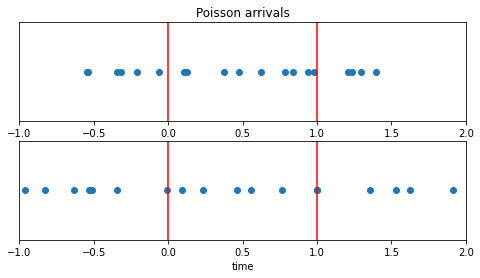

In [8]:
# sample arrivals
N = 2

arr = arrivals.sample(N)

nObs = arr[0].shape[0]


# plot arrivals
fig, ax = plt.subplots(N, figsize=(8, N*2))
for i in range(N):
    ax[i].scatter(arr[i], np.zeros(arr[i].shape[0]))
    ax[i].set_ylim([-1,1])
    ax[i].set_xlim([window.tMin - window.buff, window.tMax + window.buff])
    ax[i].set_yticklabels([])
    ax[i].set_yticks([])
    ax[i].axvline(x=window.tMin, c='r')
    ax[i].axvline(x=window.tMax, c='r')
    if i == N-1:
        ax[i].set_xlabel("time")
    if i == 0:
        ax[i].set_title("Poisson arrivals")
plt.show()

<br>

### 2. Distributions over wireless parameters

Next, we simply specify a distribution over the essential LoRaWAN parameters. To help us keep track of which parameters to specify distributions over, we can refer to the `lpf.LoRaParameters` object.

We will also make use of these parameters when computing airtimes.

In [9]:
# specify a LoRaWAN-parameters object
wan = lpf.LoRaParameters(nChannels=4)

print(wan)

A LoRa Parameters object with params:
	 nChannels: 4
	 freq: 915
	 bw: 125
	 sf: [7, 8, 9, 10]
	 overhead: 13
	 maxPow: 30
	 codingRate: 4/5
	 dwellTime: 0.4
	 dutyCycle: None


In [10]:
# specify a sperading factor distirbution
channelDist = lpd.Choice(1)  # unifom when no parameters specified
print(channelDist)

DiscreteDistribution({'a': 1, 'p': None, 'replace': True, 'seed': None})


In [11]:
# specify a sperading factor distirbution
spreadingDist = lpd.Choice(wan.sf, p=[0.1, 0.2, 0.3, 0.4])
print(spreadingDist)

DiscreteDistribution({'a': [7, 8, 9, 10], 'p': [0.1, 0.2, 0.3, 0.4], 'replace': True, 'seed': None})


In [12]:
# payload dist
payloadDist = lpd.Choice(a=[10, 11])
print(payloadDist)

DiscreteDistribution({'a': [10, 11], 'p': None, 'replace': True, 'seed': None})


In [13]:
# a power distribution
powerDist = lpd.Normal(loc=-80, scale=10)
print(powerDist)

NormalDistribution({'loc': -80, 'scale': 10, 'seed': None})


In [14]:
# Collect all parts in a LoRa distribution
loraDist = lpf.IndependentLoRaGenerator(arrivalProcess=arrivals,
                                        loraParams=wan,
                                        channelDist = channelDist,
                                        spreadingDist = spreadingDist,
                                        payloadDist = payloadDist,
                                        powerDist = powerDist)

<br>

#### Sampling and plotting traffic

In [44]:
traffic = loraDist.sample(10)  # sample 3 Traffic realizations

In [45]:
print(traffic[0])

Traffic(nObs=array(11))


# Modeling wireless interference

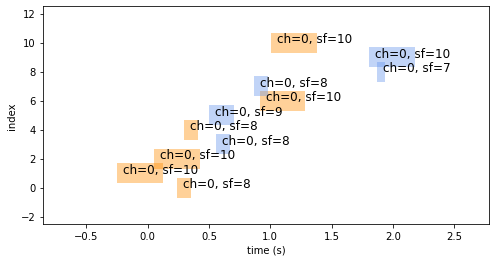

In [46]:
# plot traffic outcomes
i = 0
traffic[i].plot(text=True, figsize=(8,4), linewidths=20, labels=traffic[i].thinALOHA());

In [ ]:


    
class MaternThinning:
    """
    A Matérn thinning model.
    
    Matérn thinning is a hard-core thinning process for a collection of points
    in which each point is equipped with a mark. A ball (core) of fixed radius
    is drawn around each point. Points with overlapping cores are considered
    colliding. How collisions are resolved depends on the type. Each type is
    more forgiving than the last.
    #. Type I: All colliding points are thinned. This models scenarios in which
    it is impossible to observe points withing 2 radii of each other.
    #. Type II: Among colliding pairs, the one with the higher mark is retained,
    the other points is are thinned.
    #. Type III: Among colliding pairs, only points with colliding neighbors
    that are both higher marked *and* retained are thinned.
    
    Attributes
    ----------
    radius : float
        Fixed radius of interaction between points.
    kind : str, optional
        Default is '1', while '2' and '3' are also supported. See notes.
    
    Methods
    -------
    thin
        Thins a given (marked) point process.
        
    Notes
    -----
    The process is named after Bertil Matérn who published on them in 1962.
    """
    
    def __init__(self, radius, kind='1'):
        """
        Instantiate Matérn thinning model.
        """
        self.radius = radius
        self.kind = kind
    
    def thin(self, points, marks=None, radius=None, kind=None):
        """
        Applies Matérn thinning to a collection of points.
        
        Parameters
        ----------
        points : array_like
            An array of point coordinates of shape [nPoints, nDims] where
            nPoints is the number of points, and nDims the dimensionality
            of the space the points occupy.
        
        marks : array-like, optional
            Array of marks, used only if kind == '2' or '3'. Marks should
            support comparisons (>, <, =) and match `points` in 1st dim.
        
        radius : float, optional
            Optional radius that, if provided, overrides internal radius.
        
        kind : str, optional
            Optional kind-str that overrides internal kind if provided.
        
        Returns
        -------
        retained : array of bools
            An array of bools labeling each points is retained or thinned.
        """
   
    
        # sample start and end times of each point
        starts = [np.random.uniform(0, 3, n) for n in n_points]
        for i in range(len(starts)):
            starts[i].sort() # sort start times
        ends = [s + airtime for s in starts]
        times = [np.vstack((starts[i], ends[i])).T for i in range(len(ends))] # stack
        times = [t/airtime for t in times] # normalize times by airtime
    
        # compute overlap between points
        D = [pdist(s.reshape(len(s), 1), metric="euclidean") for s in starts]
        D = [squareform(d) for d in D]   # make full square matrices
        D = [(d < airtime)*1 for d in D] # 0-1 matrices of overlap
    
        overlap = [np.sum(d, axis=0) for d in D]
        overlap = [(ovlp > 1)*1 for ovlp in overlap]
    
        # compute dummy for overlapping with earlier point
        D = [d * (1 - np.tri(*d.shape, k=0)) for d in D] # takes upper triangle of collisions
        X = [np.sum(d, axis=0) for d in D] # vectors of nr. overlapping pre-arriving packets
    
        overlap_early = [(x > 0)*1 for x in X] # dummy overlapping with earlier point
    
        # collect data
        for i in range(len(X)):
            ones = np.ones(len(X[i]))
            zeros = np.zeros(len(X[i]))
            X[i] = np.vstack((zeros,
                              ones,
                              overlap[i],
                              overlap_early[i],
                              #starts[i]/airtime
                             )).T  # add 1s column to X
    
        # get Matérn type III inclusion
        for j in range(len(D)):
            n_points = D[j].shape[0]
            if n_points > 0:
                for i in range(1, len(D[j])):
                    if D[j][:,i].sum() > 0:
                        # reject i and remove all 1s in i's row
                        D[j][i, i:n_points] = np.zeros(n_points - i)
            X[j][:,0] = D[j].sum(axis=0)    

        
        incl  = [np.where(x[:,0]==0)[0] for x in X]
    
        X = [x[:, 1:] for x in X] # drop ground truth
    
        if kind == '2':
            # get inclusion from 3rd column: 'overlap_early'
            incl = [np.where(x[:,2]==0)[0] for x in X] 
    
        if kind == '1':
            # get inclusion from 2nd column: 'overlap'
            incl = [np.where(x[:,1]==0)[0] for x in X]
        
        return X, times, incl, D

# Simulation experiments and output analysis